<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-GenAI/blob/main/ANC_Simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Dependencies
#!pip install librosa matplotlib tensorflow

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from google.colab import files
import io
from IPython.display import Audio

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [7]:
# Upload and load the audio file
print("Please upload your noise .wav file:")
uploaded = files.upload()

Please upload your noise .wav file:


Saving Bn-ord-B3-mf-N-N.wav to Bn-ord-B3-mf-N-N.wav


Bn-ord-B3-mf-N-N.wav
Epoch [1/10], Loss: 0.0177846
Epoch [2/10], Loss: 0.0009098
Epoch [3/10], Loss: 0.0005338
Epoch [4/10], Loss: 0.0002388
Epoch [5/10], Loss: 0.0000215
Epoch [6/10], Loss: 0.0000089
Epoch [7/10], Loss: 0.0000032
Epoch [8/10], Loss: 0.0000019
Epoch [9/10], Loss: 0.0000018
Epoch [10/10], Loss: 0.0000017
SimpleCNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
)


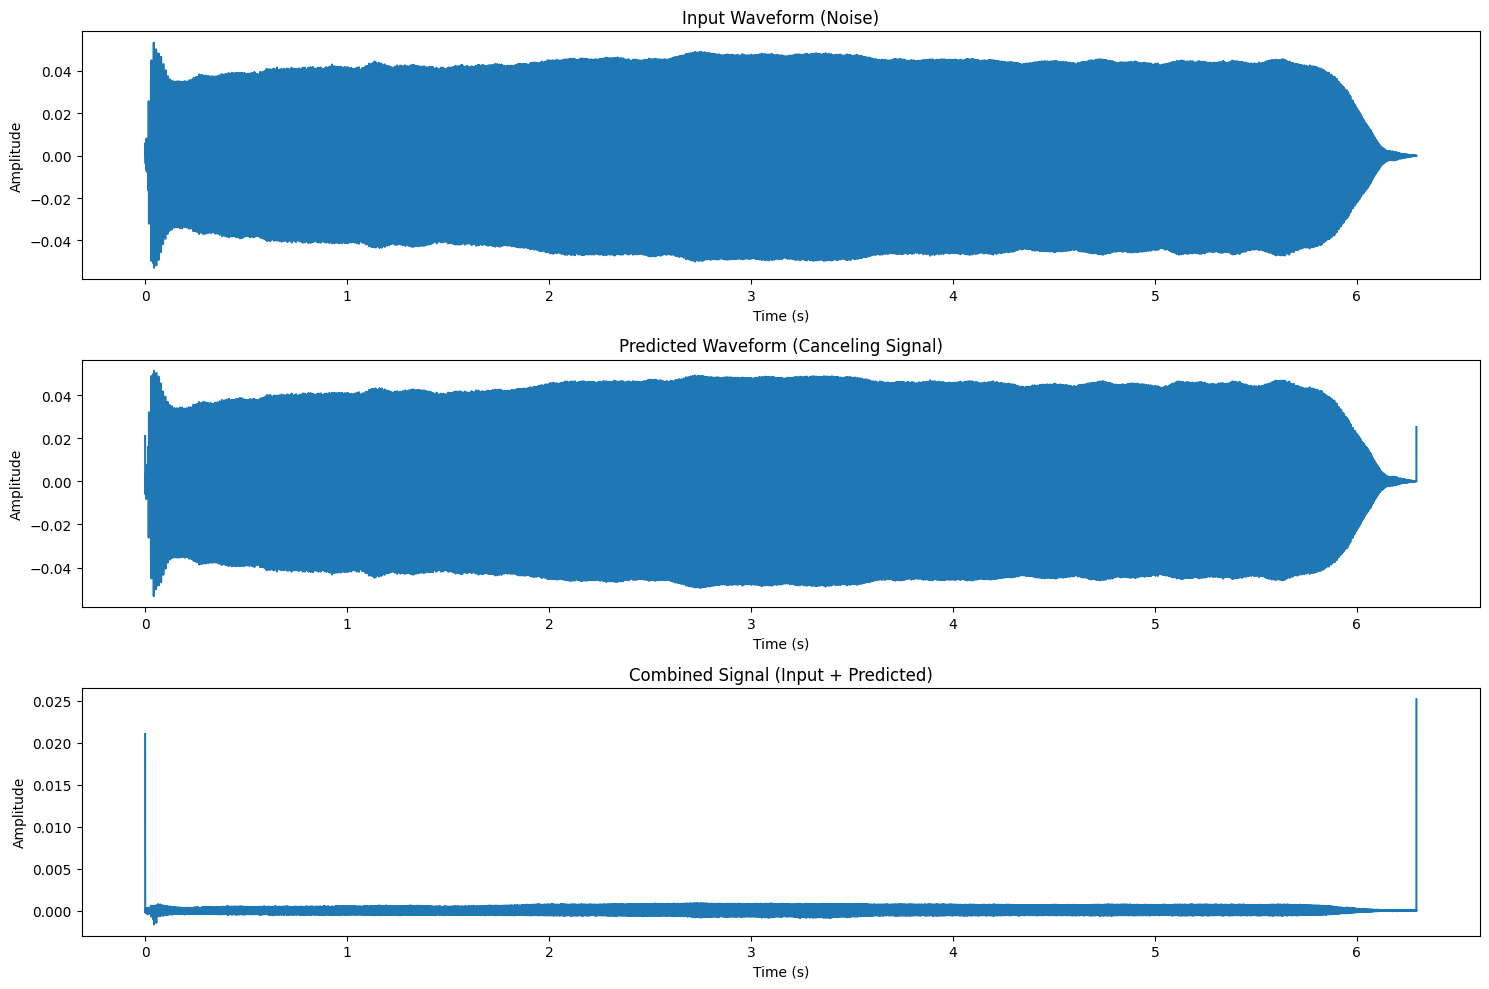

Noise reduction: 38.63 dB
Input Noise:



Predicted Cancellation Signal:



Combined Output:


In [9]:
file_name = list(uploaded.keys())[0]
print(file_name)

def load_and_preprocess_audio(file_obj):
    audio_data = file_obj.read()
    y, sr = librosa.load(io.BytesIO(audio_data))
    return y, sr

audio, sr = load_and_preprocess_audio(io.BytesIO(uploaded[file_name]))

# Data preprocessing
def create_dataset(audio, seq_length=1000, stride=100):
    X, y = [], []
    for i in range(0, len(audio) - seq_length, stride):
        X.append(audio[i:i+seq_length])
        y.append(-audio[i:i+seq_length])  # Inverted signal for noise cancellation
    return np.array(X), np.array(y)

X, y = create_dataset(audio)
X_tensor = torch.FloatTensor(X).unsqueeze(-1)
y_tensor = torch.FloatTensor(y)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define the model
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, output_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.transpose(1, 2)  # Change shape from (batch, seq_len, channels) to (batch, channels, seq_len)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x.transpose(1, 2)  # Change back to (batch, seq_len, channels)

# Initialize the model
model = SimpleCNN()

# Training function
def train_model(model, dataloader, num_epochs=10, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output.squeeze(-1), batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        #if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.7f}')

# Train the model
train_model(model, dataloader)

# Evaluation and visualization function
def predict_and_visualize(model, audio, seq_length=len(audio)):
    model.eval()

    with torch.no_grad():
        input_tensor = torch.FloatTensor(audio[:seq_length]).unsqueeze(0).unsqueeze(-1)
        predicted = model(input_tensor).squeeze().numpy()

    print(model)

    # Plot results
    t = np.arange(seq_length) / 16000  # Assuming 22050 Hz sample rate
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(t, audio[:seq_length])
    plt.title('Input Waveform (Noise)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.plot(t, predicted)
    plt.title('Predicted Waveform (Canceling Signal)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 3)
    combined = audio[:seq_length] + predicted
    plt.plot(t, combined)
    plt.title('Combined Signal (Input + Predicted)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

    # Calculate and print the reduction in signal power
    input_power = np.mean(np.square(audio[:seq_length]))
    output_power = np.mean(np.square(combined))
    reduction_db = 10 * np.log10(input_power / output_power)
    print(f"Noise reduction: {reduction_db:.2f} dB")
    # Audio Playback in Colab
    print("Input Noise:")
    display(Audio(audio, rate=22050))

    print("\nPredicted Cancellation Signal:")
    display(Audio(predicted, rate=22050))

    print("\nCombined Output:")
    display(Audio(combined, rate=22050))


# Evaluate and visualize results
predict_and_visualize(model, audio)

